# Neural Networks for Data Science Applications
## Customized activation functions


### Introduction: Trainable activation functions

Remember that a trainable variant of the Swish function can be written as:

$$ \phi(s) = (as + b)\sigma(cs + d) $$

where $s$ is the scalar input of the AF, $\left\{a, b, c, d\right\}$ are four scalar parameters, and $\sigma$ is the sigmoid function. Note how this can be (roughly) interpreted as a one-hidden layer MLP with one input, one hidden unit, and one output. Thus, we can easily generalize this as:

$$ \phi(s) = \sum_{i=1}^n (a_is+b_i)\sigma(c_is+d_i) \tag{1} $$

where $n$ is an hyper-parameter, and the function has now $4n$ parameters $\left\{a_i, b_i, c_i, d_i\right\}_{i=1}^n$. By varying $n$ we can make the activation function as complicated as we want: we say this is a **non-parametric** AF [1]. The homework will guide you to implement an MLP exploiting (1) in JAX.

In [ ]:
import jax
import jax.numpy as jnp

### Exercise 1 (1 point)

We begin by implementing (1) (no MLPs for now) in JAX. Following what we saw in the first lab session, implement equation (1) in pure JAX (no external libraries) using a pair of (init, call) functions, respectively for initializing the parameters and for computing the outputs of the AF.

For the purpose of this exercise we consider a single AF with mini-batching over the input, hence the signature of the functions should be:

```
def init_fcn(key, n):
   # key is the PNRG state
   # n is the hyper-parameter in (1)
   # Returns: the parameters (a,b,c,d) in whatever format you prefer.
```


```
def call_fcn(params, x: Float[Array, "b"])
           -> Float[Array, "b"]:
   # x is a vector (mini-batch) of b inputs to the function
   # params is the output of init_fcn
   # Returns the corresponding outputs ϕ(x1), ϕ(x2), ..., ϕ(xb).
```






✅ **Completion requirement**: Show me the two functions work as expected. For example, you can plot some randomly-initialized functions for different choices of $n$.

In [ ]:
def init_fcn(key, n):
  key1, key2, key3, key4 = jax.random.split(key, 4)
  a = jax.random.uniform(key1, (n,))
  b = jax.random.uniform(key2, (n,))
  c = jax.random.uniform(key3, (n,))
  d = jax.random.uniform(key4, (n,))
  return a, b, c, d


def call_fcn(params, x: jnp.ndarray) -> jnp.ndarray:
  a, b, c, d = params
  return jnp.sum((jnp.outer(x, a) + b) * jax.nn.sigmoid(jnp.outer(x, c) + d), axis = 1)

batch = jnp.array([2, 5, 3])
width = 5
key = jax.random.PRNGKey(0)
print(call_fcn(init_fcn(key, width), jnp.array(batch)))

[ 6.7519217 15.091206   9.489447 ]


### Exercise 2 (1 point)

One issue of non-parametric AF is that they tend to work poorly when randomly-initialized. However, it is relatively easy to fix the parameters of (1) so that the initialized functions approximate any scalar function we desire (in fact, (1) for $n \rightarrow \infty$ is a universal approximator for 1D functions).

For this exercise, write a gradient descent procedure (again, pure JAX) that given $n$ finds the optimal coefficients $\left\{a_i, b_i, c_i, d_i\right\}$ such that:

$$ \phi(s) \approx \text{ReLU}(s) $$

Note that all functions from Exercise 1 and 2 should be scalar-valued apart from mini-batching.

✅ **Completion requirement**: Show me gradient descent converges correctly. For example, you can plot the quality of the approximation when increasing $n$.

In [ ]:
@jax.jit
@jax.value_and_grad
def loss(params, x, y):
  return jnp.mean((call_fcn(params, x) - y)**2)

key = jax.random.PRNGKey(0)
relu_params = init_fcn(key, 30)
loss_history = []

x = jnp.linspace(-5, 5, 100)
#RELU OTPUTS
y = jnp.maximum(x, 0)

for i in range(800):
  l, g = loss(relu_params, x, y)
  loss_history.append(l)
  relu_params = jax.tree.map(lambda p, g: p - 0.001 * g, relu_params, g)

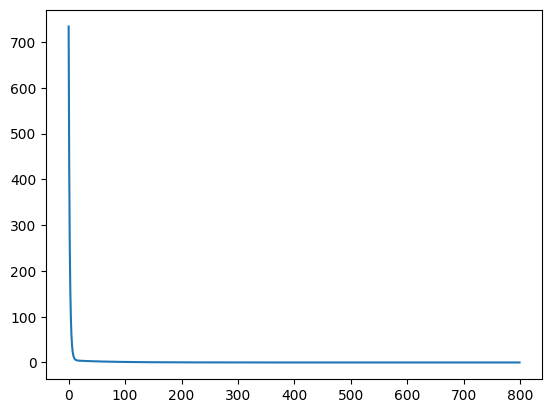

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_history)

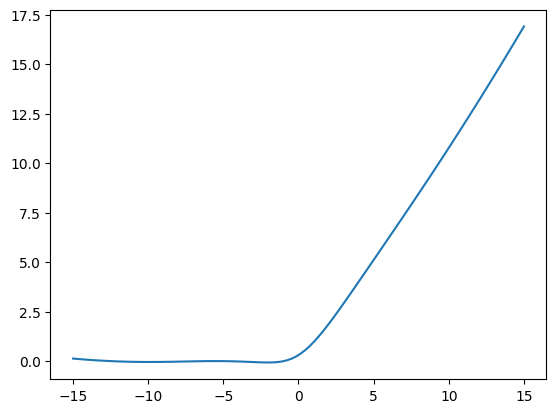

In [ ]:
x = jnp.linspace(-15, 15, 100)
plt.plot(x, call_fcn(relu_params, x))

### Exercise 3 (1 point)

Clearly, a single activation function is not enough. For example, consider the following Sequential model in Keras:

```
model = Sequential([
  Dense(5),
  ReLU(),
  Dense(1)  
])
```
We would like to replace the intermediate ReLU layer with an equivalent layer implementing (1), where each unit (neuron) in the layer is assigned a different AF. Luckily, we can use `jax.vmap` over the result of Exercise 1 to solve this.

For this exercise, apply `vmap` over `call_fcn` to obtain the following variants:

1.   A single AF (shared parameters) for all the units of the layer.
2.   Different AFs (different parameters) for each unit in the layer.
3. (**Optional, more difficult**) A KAN-style AF [2] where a different AF is applied to each edge of a fully-connected layer.

The signature of all vmapped functions should be:

```
def vmapped_call_fcn(params, x: Float[Array, "b h"])
           -> Float[Array, "b h"]:
   ...
```
where $x$ is a generic output of a fully-connected layer, so that $h$ is the number of hidden units in the layer (e.g., $h=5$ for the first `Dense` layer above). For the new initialization functions, you are free to either rewrite them or find some way to vectorize the original one.

✅ **Completion requirement**: Show me the vectorization works as expected (e.g., generate and visualize multiple functions simultaneously).

In [ ]:
#If Different Parameters - different activation functions for train,
#if not Different Parameters - same activation function for train
def vmapped_init_fcn(key, n, h = 1, DiffParams = True):
  if DiffParams:
    subkeys = jax.random.split(key, h)
    return jax.vmap(init_fcn, in_axes = (0, None))(subkeys, n)
  else:
    return init_fcn(key, n)

def vmapped_call_fcn(params, x: jnp.ndarray, DiffParams = True):
  #x shape: (batch_size, hiden_units)
  #params shape: (a, b, c, d) - each shape (n_terms, )
  if DiffParams == False:

    call_fcn_hidden = jax.vmap(call_fcn, in_axes=(None, 0))
    #Vectorizing over batch
    vmapped_call_fcn = jax.vmap(call_fcn_hidden, in_axes=(None, 0))
    return vmapped_call_fcn(params, x)

  else:
    #0 first, because also vectorizing params
    call_fcn_hidden = jax.vmap(call_fcn, in_axes=(0, 0))

    vmapped_call_fcn = jax.vmap(call_fcn_hidden, in_axes=(None, 0))
    return vmapped_call_fcn(params, x)

In [ ]:
# HyperParams
batch_size = 10
hidden_units = 5
n_terms = 30

Activated outputs shape: (10, 5, 1)


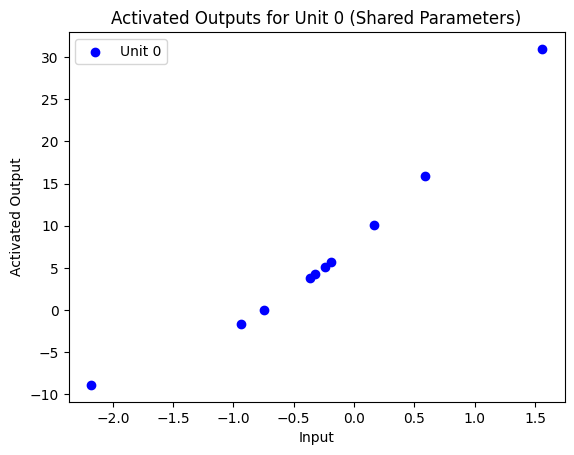

In [ ]:
# Input Generation
key = jax.random.PRNGKey(0)
x = jax.random.normal(key, (batch_size, hidden_units))

# Shared Params
key, subkey = jax.random.split(key)
params_shared = vmapped_init_fcn(key, n_terms, DiffParams = False)


activated_outputs = vmapped_call_fcn(params_shared, x, DiffParams=False)

print("Activated outputs shape:", activated_outputs.shape)
unit_index = 0  # Index of the unit to visualize

plt.scatter(x[:, unit_index], activated_outputs[:, unit_index], c='blue', label=f'Unit {unit_index}')
plt.xlabel('Input')
plt.ylabel('Activated Output')
plt.title(f'Activated Outputs for Unit {unit_index} (Shared Parameters)')
plt.legend()
plt.show()

Activated outputs shape: (10, 5, 1)


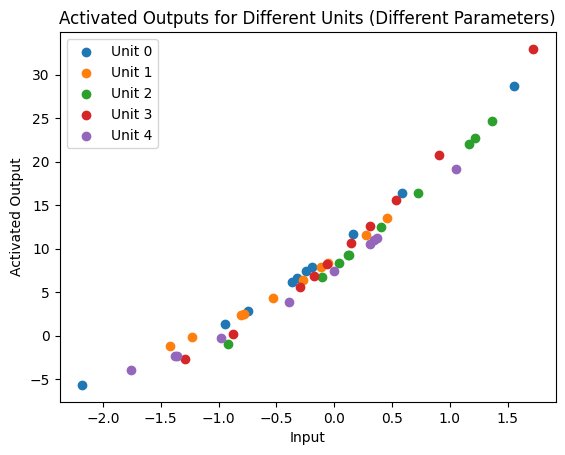

In [ ]:
#Defining Different Activation Function for each neuron
activation_params = vmapped_init_fcn(key, n_terms, hidden_units, DiffParams=True)

# activated_outputs = vmapped_call_fcn_different(activation_params, x)
activated_outputs = vmapped_call_fcn(activation_params, x, DiffParams=True)
print("Activated outputs shape:", activated_outputs.shape)

for unit_index in range(hidden_units):
    plt.scatter(x[:, unit_index], activated_outputs[:, unit_index], label=f'Unit {unit_index}')
plt.xlabel('Input')
plt.ylabel('Activated Output')
plt.title('Activated Outputs for Different Units (Different Parameters)')
plt.legend()
plt.show()

### Exercise 4 (2 point)

It is now time to train an MLP with our new activation functions. To begin with, select any **tabular dataset** that you like, for either classification or regression. A few repositories that you can look at:

1. The catalog of [TensorFlow Datasets](https://www.tensorflow.org/datasets/).
2. The [Kaggle catalog](https://www.kaggle.com/data). For downloading data from Kaggle on Google Colab, you will need to [load your Kaggle authentication token](https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb).
3. The [UCI Machine Learning Repository](https://archive.ics.uci.edu/datasets).
4. The [🤗 HuggingFace Datasets](https://huggingface.co/docs/datasets/) repository.

You are not bound to these; any open repository is okay. The choice of dataset will not influence the mark.

The objective of the exercise is to train an MLP with one hidden layer having as activation functions (1). In order to do this you have multiple choices:

1. You can do this completely in JAX by defining a new pair of (init, call) functions describing the complete model and performing gradient descent with these.
2. If you want to use Keras (note: `.fit` is *not allowed*) as in the second lab session, you need to port the trainable function in Keras. My suggestion is to subclass the `Layer` object by wrapping the functions you have already created (https://keras.io/guides/making_new_layers_and_models_via_subclassing/). The resulting layer will be backend-specific, which is not an issue. If you want something slightly harder, you can rewrite everything with Keras ops to make it backend-agnostic.
3. You can also use some high-level JAX library (e.g., Equinox, Haiku, ...). In this case, please document the code precisely.

✍ **DESCRIPTION OF THE DATASET**

*Provide a small description of the dataset below (e.g., source, task, bibliographic reference if necessary...), both as text and in the comments of the code.*

**TODO**: add description here (1-2 paragraphs).

Source: https://archive.ics.uci.edu/dataset/186/wine+quality
It consists of physicochemical properties and quality ratings of Portuguese "Vinho Verde" wine samples. The dataset is divided into two subsets: red wine and white wine. Each sample includes 11 physicochemical attributes such as fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, and alcohol content.

I will use red wine dataset for this exercise.
The primary objective is to predict the wine quality score based on the physicochemical properties, making it a regression problem.

Reference: P. Cortez, A. Cerdeira, F. Almeida, T. Matos, and J. Reis. "Modeling wine preferences by data mining from physicochemical properties." Decision Support Systems, Elsevier, 47(4):547-553, 2009.

✅ **Completion requirement**: Show me the model trains as expected (e.g., loss, accuracy). It would be nice to visualize the functions before and after training.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Loading Wine quality Dataset
url_red = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
data = pd.read_csv(url_red, sep=';')


X = data.drop('quality', axis=1).values
y = data['quality'].values

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Converting to JAX
X_train = jnp.array(X_train)
X_test = jnp.array(X_test)
y_train = jnp.array(y_train)
y_test = jnp.array(y_test)

In [ ]:
#Creating Params For the Model
def init_model(key, n_features, n_hidden, n_terms, start_activation_params):

    a_start, b_start, c_start, d_start = start_activation_params  # Each of shape (n_terms,)

    a = jnp.tile(a_start[None, :], (n_hidden, 1))  # Shape: (n_hidden, n_terms)
    b = jnp.tile(b_start[None, :], (n_hidden, 1))
    c = jnp.tile(c_start[None, :], (n_hidden, 1))
    d = jnp.tile(d_start[None, :], (n_hidden, 1))

    activation_params = (a, b, c, d)

    key = jax.random.PRNGKey(42)
    n_features = X_train.shape[1]

    key, subkey_w, subkey_b0 = jax.random.split(key, 3)
    w = jax.random.normal(subkey_w, (n_hidden, n_features))  # Shape: (n_hidden, n_features)
    b0 = jax.random.normal(subkey_b0, (n_hidden,))

    params = (w, b0, activation_params)


    return params

In [ ]:
#   Model implementation with:
#1)Weight Matrix Multiplication and adding bias
#2)Using Activation Functions in Neurons
#3)Squeezing and summing
def model(params, x):
    w, b0, activation_params = params
    y_pred = x @ w.T + b0
    y_pred = vmapped_call_fcn(activation_params, y_pred, True)
    y_pred = y_pred.squeeze()
    y_pred = y_pred.sum(axis = 1)

    return y_pred


In [ ]:
@jax.jit
@jax.value_and_grad
def loss_fn(params, x, y):
    y_pred = model(params, x)
    loss = jnp.mean((y_pred - y) ** 2)
    return loss

In [ ]:
#Importing Optax in order to use better optimizer
import optax
num_epochs = 1000
loss_history = []

#Using Relu Parameters as a Starting because otherwise, activation functions won't be emproving
params = init_model(key, n_features, n_hidden, n_terms, relu_params)

optimizer = optax.adam(learning_rate=0.001)
opt_state = optimizer.init(params)

for i in range(num_epochs):
    loss, grads = loss_fn(params, X_train, y_train)
    loss_history.append(loss)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

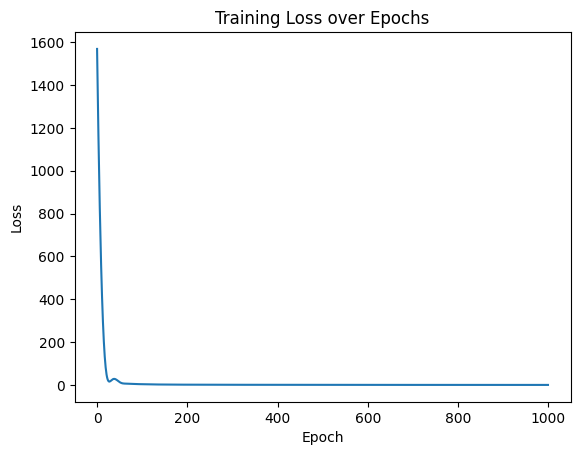

In [ ]:
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

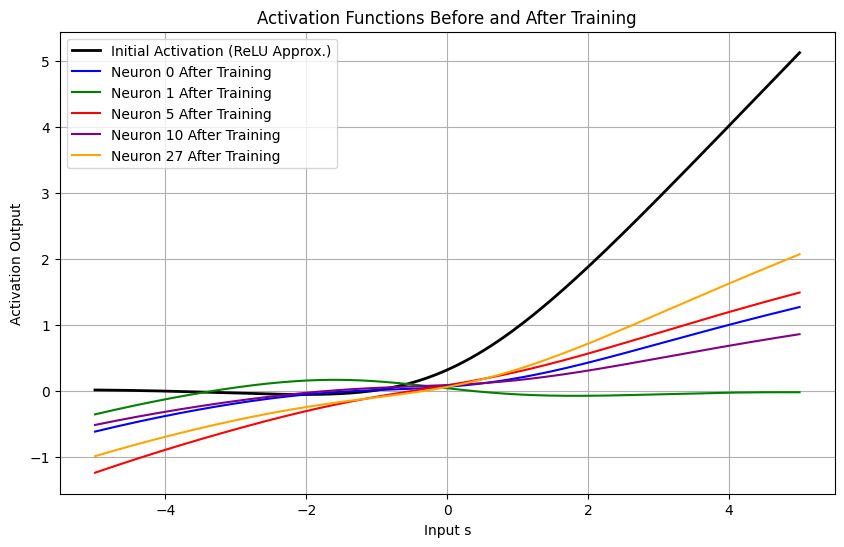

In [ ]:
# Generating a range
s_values = jnp.linspace(-5, 5, 200)

initial_params = relu_params
#Activation before training - aprox ReLu
activation_initial = call_fcn(initial_params, s_values)

#Neurons Activation Functions We Visualize
neuron_indices = [0, 1, 5, 10, 27]

#Extracting Activation Params After Training
trained_activation_params = params[2]

#Computing and Saving Activations for linspace
activation_trained_list = []
for idx in neuron_indices:
    a_trained, b_trained, c_trained, d_trained = trained_activation_params
    params_trained = (a_trained[idx], b_trained[idx], c_trained[idx], d_trained[idx])

    activation_trained = call_fcn(params_trained, s_values)
    activation_trained_list.append(activation_trained)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(s_values, activation_initial, label='Initial Activation (ReLU Approx.)', color='black', linewidth=2)

# Plotting the activation functions after training for selected neurons
colors = ['blue', 'green', 'red', 'purple', 'orange']

for idx, activation_trained in zip(range(len(neuron_indices)), activation_trained_list):
    color = colors[idx % len(colors)]
    plt.plot(s_values, activation_trained, label=f'Neuron {neuron_indices[idx]} After Training', color=color)

#Labels and Legend
plt.title('Activation Functions Before and After Training')
plt.xlabel('Input s')
plt.ylabel('Activation Output')
plt.legend()
plt.grid(True)
plt.show()

In [172]:
#Evaluating Model on Test Data
y_pred_test = model(params, X_test)

mse_test = jnp.mean((y_pred_test - y_test) ** 2)
mae_test = jnp.mean(jnp.abs(y_pred_test - y_test))
rmse_test = jnp.sqrt(mse_test)

print(f'Model on Test Data:')
print(f'MSE: {mse_test:.4f}')
print(f'MAE: {mae_test:.4f}')
print(f'RMSE: {rmse_test:.4f}')

#Evaluting Basic Approach with just approximating everyhing with y_train Mean
y_baseline = jnp.full_like(y_test, jnp.mean(y_train))

mse_baseline = jnp.mean((y_baseline - y_test) ** 2)
mae_baseline = jnp.mean(jnp.abs(y_baseline - y_test))
rmse_baseline = jnp.sqrt(mse_baseline)

print(f'\nBasic Approach (predicting the average of y_train):')
print(f'MSE: {mse_baseline:.4f}')
print(f'MAE: {mae_baseline:.4f}')
print(f'RMSE: {rmse_baseline:.4f}')

#Results Comparission
print('\n#Results Comparission:')
print(f'MSE Emprovement: {mse_baseline - mse_test:.4f}')
print(f'MAE Emprovement: {mae_baseline - mae_test:.4f}')
print(f'RMSE Emprovement: {rmse_baseline - rmse_test:.4f}')

print('\nThis is pretty good result considering that scores are between 0 and 10')

Model on Test Data:
MSE: 0.5638
MAE: 0.5854
RMSE: 0.7509

Basic Approach (predicting the average of y_train):
MSE: 1.1219
MAE: 0.7594
RMSE: 1.0592

#Results Comparission:
MSE Emprovement: 0.5581
MAE Emprovement: 0.1740
RMSE Emprovement: 0.3083

This is pretty good result considering that scores are between 0 and 10


### References

[1] Apicella, A., Donnarumma, F., Isgrò, F. and Prevete, R., 2021. A survey on modern trainable activation functions. Neural Networks, 138, pp. 14-32.

[2] Liu, Z., Wang, Y., Vaidya, S., Ruehle, F., Halverson, J., Soljačić, M., Hou, T.Y. and Tegmark, M., 2024. KAN: Kolmogorov-Arnold networks. arXiv preprint arXiv:2404.19756.